In [1]:
# Import routines
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import glob

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

import pandas as pd

import os
from PIL import Image, ImageChops

In [2]:
# Definitions

def Transform_NASAWorldview_Geotiff(file):
    # spatial reference system of cartopy maps
    target_proj = ccrs.NorthPolarStereo(central_longitude=10)
    #print(file)
    file_out = file.replace(".tiff", "_reprojected.tiff")
    gdal.Warp(file_out,
              file,
              dstSRS = target_proj.proj4_init)
    print(file_out)


def read_worldview_reprojected(file):
    img = gdal.Open(file)
    data = img.ReadAsArray()
    # make background from black to white
    ix = data.sum(axis=0) == 0
    data[..., ix] = 255
    # get extent
    gt = img.GetGeoTransform()
    extent = (gt[0], gt[0] + img.RasterXSize * gt[1],
              gt[3] + img.RasterYSize * gt[5], gt[3])
    data = data.transpose((1, 2, 0))
    return data, extent


def trim(im):
        bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
        diff = ImageChops.difference(im, bg)
        diff = ImageChops.add(diff, diff, 2.0, -100)
        bbox = diff.getbbox()
        if bbox:
                return im.crop(bbox)

In [3]:
# Transform snapshot from Nasa Worldview to Cartopy maps format

file = "/Users/marcusklingebiel/Documents/Python_routines/8_FlighttracksFrom_ACLOUD_AFLUX_MOSAiCACAS/GeoTiff_from_NasaWorldview/WorldviewSnapshots/snapshot-2022-04-01T00_00_00Z.tiff"
Transform_NASAWorldview_Geotiff(file)

ERROR 1: PROJ: proj_create_from_name: Cannot find proj.db


/Users/marcusklingebiel/Documents/Python_routines/8_FlighttracksFrom_ACLOUD_AFLUX_MOSAiCACAS/GeoTiff_from_NasaWorldview/WorldviewSnapshots/snapshot-2022-04-01T00_00_00Z_reprojected.tiff


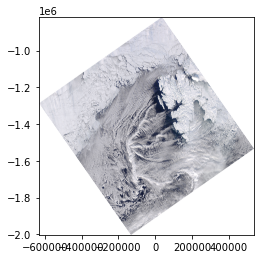

In [4]:
#Load reprojected GeoTiff Image

file = file[:-5]+"_reprojected.tiff"
img, extent = read_worldview_reprojected(file)

plt.imshow(img,extent=extent, origin='upper')

Text(0, 0.5, 'Latitude')

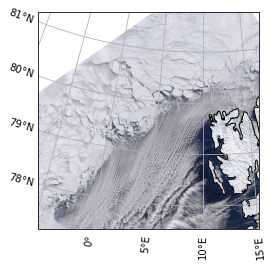

In [5]:
# Plot satellite picture on map

plt.figure(figsize=(4, 4))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=10))
ax.set_extent([-5, 15, 77.5, 81.5], crs=ccrs.PlateCarree())

ax.coastlines(resolution='10m')
ax.imshow(img,extent=extent, origin='upper')

#---------------------------------------------------
# Plot flight track
#ax.plot(lon_halo,lat_halo,
#         color='blue', linewidth=1,
#         transform=ccrs.PlateCarree(),
#         label="HALO"
#         )

# Plot dropsondes
#ax.scatter(ls_ds_lon,ls_ds_lat, marker="+", transform=ccrs.PlateCarree(), color="brown", zorder = 3)
#---------------------------------------------------

gl =  ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

gl.top_labels = False
gl.right_labels = False

plt.xlabel("Longitude")
plt.ylabel("Latitude")


In [6]:
def CloudFraction_from_SatPic(clat, clon, width, height, img):
    plt.figure(figsize=(4, 4))
    ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=10))
    ax.set_extent([clon-width, clon+width, clat-height, clat+height], crs=ccrs.PlateCarree())

    ax.coastlines(resolution='10m')
    pic = ax.imshow(img,extent=extent, origin='upper')
    ax.axis('off')

    #ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    plt.savefig("CutOut.png", dpi=300, transparent = True, bbox_inches="tight")
    
    img = Image.open("CutOut.png").convert('RGB')

    # Remove frame
    img_frameless = trim(img)

    # Transform to BW
    thresh = 120
    fn = lambda x : 255 if x > thresh else 0
    image_bw = trim(img.convert("L").point(fn, mode='1'))


    # Count white and black pixels
    black = 0
    white = 0

    for pixel in image_bw.getdata():
        #print(pixel)
        if pixel == (255): # if your image is RGB (if RGBA, (0, 0, 0, 255) or so

            white += 1
        else:
            black += 1
    print('black=' + str(black)+', white='+str(white))
    print("Cloud fraction = " + str(white/(black+white)* 100) + " %")
    cf = white/(black+white)* 100
    
    img_frameless.save("Img_frameless.png")
    image_bw.save("Img_bw.png")
    
    return cf
    

black=758723, white=32215
Cloud fraction = 4.07301204392759 %


4.07301204392759

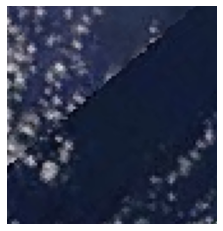

In [7]:
CloudFraction_from_SatPic(79, 10, 0.5, 0.1, img)